# Improving Montreal's BIXI Bikeshare System

In [1]:
#used libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import folium
from folium import plugins
import re
import math
from haversine import haversine, Unit
from datetime import datetime, date, time
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import namedtuple
import geopandas as gpd
from folium.plugins import HeatMap

### Why Bikeshare?

Bikeshare systems are an alternative form of public transport to traditional buses and subways which allow users to pick up and drop of shared bikes at specific stations around the city. The use of the bikeshare system has been increasing, making it an important feature to consider in the city's complete transport system. In the last year however it has begun to decrease; an improvement of the system may be able to bring usage back up. Biking is both more environmentally friendly and more healthy than automobiles, and incorporating this system is a benefit to the city's inhabitants. we thus want to analyse the system to see how people currenlty use the system and then find improvements to maximize and encourage the use of this beneficial form of transport. We especially want to analyse it with respect to it's interactions and incorportation with other tranport infrastructures. 

In [2]:
#load the bixi data
data = pd.read_pickle("../combined_new_stations")
stations = pd.read_pickle("../stations")

In [3]:
#create a dataframe which lists the number of uses of each station
use = data.groupby(['year','start_station_code']).size().reset_index(name='counts')
use_dur = data[['year','start_station_code','duration_sec']].groupby(['year','start_station_code']).mean().reset_index()
use['duration'] = use_dur['duration_sec']

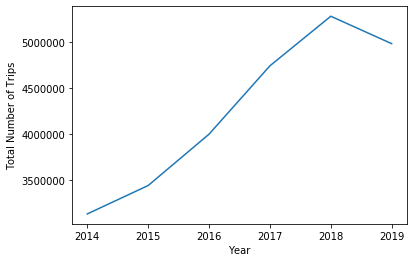

In [4]:
#total number of trips - group the trips by year to see how popular the system is each year
trips = use.groupby('year').sum()
plt.plot(trips.index, trips.counts)
plt.ylabel('Total Number of Trips')
plt.xlabel('Year')
plt.show()

### Research Questions
1. Do the trips taken align with existing public transport lines or are they used to fill the gaps of the public transport routes?
2. Are some areas of Montreal more bike-friendly than others (i.e. have bike lanes or are smaller roads) and is this bike friendliness correlated with more trips done in that area?

# Datasets
To complete our analysis we worked with several different datasets:
1. BIXI Bikeshare trips (type = .csv, files = data for each year and month, station locations and codes for each year)
2. Montreal weather data (type = .csv, files = ...... )
3. Public transport schedule (type = , files = )
4. Bike paths (type = .geojson, files = )

Each of these datasets was treated in a different way in order to compile everything into a format where the data could be compared

### Bikeshare dataset

The first task was to combine the separate files for each year and month into a single dataframe. The station data (coordinates) was also merged and the dates converted to datetime and separated by year, month, day and hour for ease of analysis later. Additionally the 'distance' (more accurately displacement) of each trip was calculated using the haversine function (this is the straight line between the start and end station and does not reflect the actual distance traveled by the bike). 

The data was very clean already, with no NaNs, consistent formatting, and a reasonable looking distribution. We will focus on the data from 2019 for our analysis since public transport schedules and infrastructure, as well as the bike share infrastructure change each year, so in order to compare we need to look at a single year. For example the BIXI stations with the same code can change locations each year. The bus schedule also differs and bike lanes are added/demolished.

In [5]:
#round trip distribution
data_og = pd.read_pickle("../combined_data_old")
return_trip = data_og[data_og['distance']==0.0]
plt.hist(return_trip['duration_sec'], bins=100)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../combined_data_old'

The above plot illustrates the distribution of return trips (start and end stations are the same). There is a disproportionately high number of trips which return to the same station at a very small duration. This is likely from broken bikes which are signed out but then returned very quickly to the same station. We thus decided to remove these data points, elminating any trips which returned to the same station and have a duration of less than 3 minutes. 

In [6]:
#2019 data only
data19 = pd.read_pickle("../combined2019")
data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,latitude_start,longitude_start,latitude_end,longitude_end,year,month,start_day,start_hour,end_day,end_hour
0,2014-04-15 00:01:00,6209,2014-04-15 00:18:00,6436,1061,1,45.512541,-73.570677,45.485801,-73.595797,2014,4,15,0,15,0
1,2014-04-15 00:01:00,6214,2014-04-15 00:11:00,6248,615,1,45.516091,-73.570129,45.518593,-73.581566,2014,4,15,0,15,0
2,2014-04-15 00:01:00,6164,2014-04-15 00:18:00,6216,1031,1,45.533314,-73.583737,45.514840,-73.584779,2014,4,15,0,15,0
3,2014-04-15 00:01:00,6214,2014-04-15 00:24:00,6082,1382,1,45.516091,-73.570129,45.549900,-73.583084,2014,4,15,0,15,0
4,2014-04-15 00:02:00,6149,2014-04-15 00:08:00,6265,347,1,45.538670,-73.569360,45.539259,-73.577459,2014,4,15,0,15,0


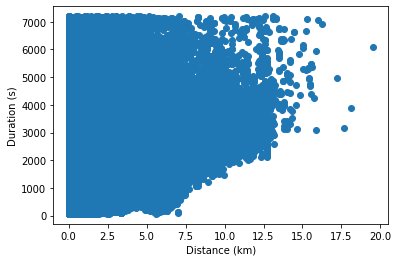

In [7]:
#raw data plot
plt.scatter(data19.distance, data19.duration_sec)
plt.ylabel('Duration (s)')
plt.xlabel('Distance (km)')
plt.show()

As expected the bottom right corner of the plot has no data points since there is a limit to how fast bikers can travel between two stations. 

# BIXI Bikeshare System

We first wanted to get a general idea of how the system was being used and what kind of trips were taken on it. We also looked at the setup, including distribution of stations across the city. 

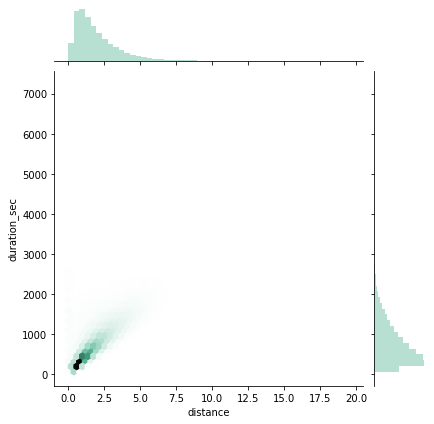

In [8]:
#distance vs duration for 2019 (all months)
sns.jointplot(data19.distance, data19.duration_sec, kind='hex', color="#4CB391")
plt.show()

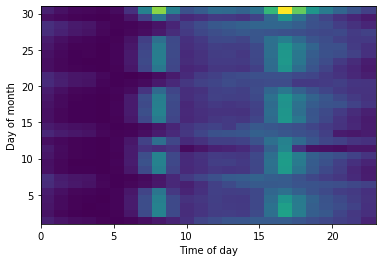

In [9]:
#time of day of usage (start of usage) vs days of the year (with overall histograms on the side)
byDay = data19.query('month==7')
plt.hist2d(byDay.start_hour, byDay.start_day, bins=[24,30])
plt.xlabel('Time of day')
plt.ylabel('Day of month')
plt.show()

We can see the system is mostly used for short distance trips indicating use for commuting. We see a linear relationship between distance and duration indicating most people take around the same time to bike from one station to the next and not many are completing touring rides (which would appear as a relatively long duration for a short distance). In addition the increased use around the hours that people go to and get off work supports this conclusion.

### Which stations are the most popular?

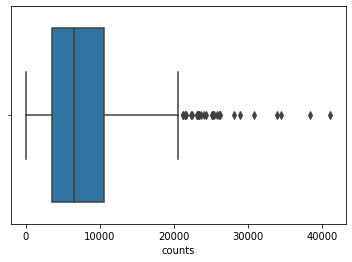

In [10]:
#station use count (by number of rides starting from that station)
station_use = data19.groupby(['start_station_code']).size().reset_index(name='counts')
use_dur = data19[['start_station_code','duration_sec']].groupby(['start_station_code']).mean().reset_index()
station_use['duration'] = use_dur['duration_sec']

station_use = station_use.merge(stations[['latitude','longitude']], how='left', left_on=['start_station_code'], right_on=['code'])
sns.boxplot(x=station_use['counts'])

In [11]:
#location of montreal
montreal = [45.5017, -73.5673]

#station popularity as a heatmap
hm = folium.Map(location=montreal, tiles='Stamen Toner', zoom_start=14)
HeatMap(data=station_use[['latitude', 'longitude', 'counts']], radius=8, max_zoom=13).add_to(hm)
hm

We can see that most trips are started downtown around the old town. 

### Which routes are the most popular?

Now instead of looking at where people start their rides, we want to look at the actual paths that are most common. This is the format we want our data in to compare to bike lane density and public transport lines. For this we create a 'paths' dataframe:

In [12]:
#create dataframe with the paths taken and the frequency as well as duration
data_sub = data19[['start_station_code','end_station_code','latitude_start','longitude_start','latitude_end','longitude_end','distance']]
paths = data19.groupby(['start_station_code','end_station_code']).size().reset_index(name='counts')
paths_dur = data19[['start_station_code','end_station_code','duration_sec']].groupby(['start_station_code','end_station_code']).mean().reset_index()
paths['duration'] = paths_dur['duration_sec']
paths = paths.merge(data_sub.drop_duplicates(), how='left', on=['start_station_code','end_station_code'])
paths.head()

,start_station_code,end_station_code,counts,duration,latitude_start,longitude_start,latitude_end,longitude_end,distance
0,4000,4000,103,1173.126214,45.549598,-73.541874,45.549598,-73.541874,0.000000
1,4000,4002,1,1864.000000,45.549598,-73.541874,45.516937,-73.640483,8.496129
2,4000,5007,1,3585.000000,45.549598,-73.541874,45.523319,-73.520127,3.377533
3,4000,6001,53,1411.509434,45.549598,-73.541874,45.510351,-73.556508,4.510499
4,4000,6002,95,504.852632,45.549598,-73.541874,45.539385,-73.541000,1.137631


We can also visualize the most frequent routes taken:

In [13]:
#the following functions are used to draw arrows for the direction of travel of the bike routes
# source: https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e 
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

def get_arrows(locations, color='black', size=6, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill=True, fill_color=color, color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

In [14]:
#create a map with the most popular stations and most popular routes (between two particular stations)
#create the map
m = folium.Map(location=montreal, tiles='cartodbpositron', zoom_start=13)

#plot the most popular stations (red, marker diameter proportional to popularity)
station_pop = station_use.query('counts>15000')
for lat, lng, name, count in zip(station_pop.latitude, station_pop.longitude, station_pop.start_station_code, station_pop.counts):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=count/10000, popup=name, fill_color='red', color='red'))

#take only routes which have more than 1000 uses
vis = paths.query('counts>1000')

#plot lines between the stations according to number of trips taken (thicker line= more trips taken)
for index, row in vis.iterrows():
    folium.PolyLine([[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], color="green", weight=row['counts']/500).add_to(m) 
    arrows = get_arrows(locations=[[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], n_arrows=1)
    for arrow in arrows:
        arrow.add_to(m)
    
#put marker for end stations that are not one of the popular start stations   (in blue) 
filt = vis[~vis['end_station_code'].isin(station_pop['start_station_code'])]
for lat, lng, name in zip(filt.latitude_end,filt.longitude_end,filt.end_station_code):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill=True, radius=2, popup=name, fill_color='blue', color='blue'))
    
m

In [15]:
m.save("results/bike_routes")

- Red dots are one of the most popular stations to start from
- Lines are the most popular routes to take
- Blue dotes are end points which are not one of the most popular stations


In [16]:
def plot_paths(station, start):
    '''
    Returns map with paths to/from chosen station plotted as lines
    
    Parameters
    station : int of station code
    start : boolean, (if True plots trips starting from that station, if false plots rides ending at that station)
    
    Return
    folium map
    
    Note:
    uses 'paths' dataframe
    '''
    
    if start==True:
        point = 'start'
        to = 'end'
    else:
        point = 'end'
        to = 'start'

    filt = paths.query('%s_station_code==@station'%point).reset_index(drop=True)

    #create the map and initialize parameters
    montreal = [45.5017, -73.5673]
    smap = folium.Map(location=montreal, tiles='Stamen Terrain', zoom_start=13)
    start_station = filt.loc[1,['latitude_%s'%point,'longitude_%s'%point]]
    
    #add the markers
    smap.add_child(folium.Marker(location=start_station), name=str(station))
    for lat, lng, name in zip(filt['latitude_%s'%to],filt['longitude_%s'%to],filt['%s_station_code'%to]):
        smap.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=2, popup=name, fill_color='red', color='red')) #CircleMarker gives dot, Marker gives drop 
    
    #add the lines (all going in same direction so don't need to add arrows (either towards or away from the station of interest))   
    for index, row in filt.iterrows():
        folium.PolyLine([start_station,[row['latitude_%s'%to],row['longitude_%s'%to]]], color="green", weight=row['counts']/100).add_to(smap) 
    return smap

In [17]:
stat50 = station_use.sort_values(by='counts',ascending=False)
stat50 = stat50.head(50)
stat50.head()

,start_station_code,counts,duration,latitude,longitude
132,6136,41091,544.642330,45.527616,-73.589115
178,6184,38304,640.874713,45.524673,-73.582550
56,6052,34511,1165.059256,45.497515,-73.552571
97,6100,33931,807.522295,45.496590,-73.578510
215,6221,30870,681.799255,45.519410,-73.586850


In [18]:
m_onestat = plot_paths(6136, True)
m_onestat.save('most_pop_path.html')

# Bike friendly roads : Do they increase BIXI use?

Do people use bikes more in areas with lots of dedicated bike paths?

### General cleaning of the bike paths dataset

In [19]:
fname = "./BikePaths/reseau_cyclable_2018_c.geojson"
bp = gpd.read_file(fname)
bp.head(3)

,ID,ID_TRC_GEO,TYPE_VOIE,TYPE_VOIE2,LONGUEUR,NBR_VOIE,SEPARATEUR,SAISONS4,PROTEGE_4S,Ville_MTL,NOM_ARR_VI,geometry
0,8998.0,1230109.0,4.0,0.0,90.0,2.0,M,OUI,OUI,OUI,Le Plateau-Mont-Royal,(LINESTRING Z (-73.59024203982732 45.532589280...
1,2.0,0.0,5.0,0.0,20.0,2.0,None,NON,NON,OUI,Rivi�re-des-Prairies�Pointe-aux-Trembles,(LINESTRING Z (-73.49679478102101 45.695741649...
2,3.0,1623974.0,1.0,0.0,36.0,2.0,None,NON,NON,OUI,Rivi�re-des-Prairies�Pointe-aux-Trembles,(LINESTRING Z (-73.57344998170396 45.658526272...


In [20]:
bp = bp[bp['Ville_MTL']=='OUI']
bp = bp.reset_index(drop=True)
bp = bp.drop(columns=['ID', 'ID_TRC_GEO', 'TYPE_VOIE', 'TYPE_VOIE2', 'SEPARATEUR', 'SAISONS4', 'PROTEGE_4S', 'Ville_MTL'])

In [21]:
bp.head(3)

,LONGUEUR,NBR_VOIE,NOM_ARR_VI,geometry
0,90.0,2.0,Le Plateau-Mont-Royal,(LINESTRING Z (-73.59024203982732 45.532589280...
1,20.0,2.0,Rivi�re-des-Prairies�Pointe-aux-Trembles,(LINESTRING Z (-73.49679478102101 45.695741649...
2,36.0,2.0,Rivi�re-des-Prairies�Pointe-aux-Trembles,(LINESTRING Z (-73.57344998170396 45.658526272...


### Informations about the global dataset

In [22]:
mean_length = bp.LONGUEUR.mean()
print("Mean length of a bike path : ", np.round(mean_length, 2), " m")
sum_length = bp.LONGUEUR.sum()
print("Cumulative length of all bike paths : ", sum_length, " m")

Mean length of a bike path :  133.5  m
Cumulative length of all bike paths :  752779.0  m


In [23]:
bp_json = f'./BikePaths/reseau_cyclable_2018_c.geojson'

m_bike_json = folium.Map([45.52,-73.7], tiles='stamentoner', zoom_start=11)
folium.GeoJson(bp_json).add_to(m_bike_json)

#m_bike_json
#m_bike_json.save("results/Bike_Paths.html")

In [24]:
%%HTML
<iframe width="100%" height="350" src="results/Bike_Paths.html"></iframe>

As you can see on this map, the dedicated bicycle paths are not evenly distributed throughout Montréal. We would like to see if these dedicated paths encourage BIXI system users to cycle between two stations with more of this type of path.

### Adding individual distances between points

In [25]:
bp['distances'] = bp.apply(lambda x: np.array([]),axis=1)

In [26]:
# Calculates the distances between each consecutive point in the geometry list

Recompute_densities = False
if Recompute_densities:
    for k in range(len(bp)):
        distances = []
        for l in range(len(bp['geometry'][k])):
            subdistances = np.array([])
            for m in range(len(bp['geometry'][k][l].xy[0])-1):
                subdistances = np.append(subdistances, 1000*haversine((bp['geometry'][k][l].xy[1][m], bp['geometry'][k][l].xy[0][m]),(bp['geometry'][k][l].xy[1][m+1], bp['geometry'][k][l].xy[0][m+1])))
            distances.append(subdistances)
        bp['distances'][k] = np.array(distances)

In [27]:
bp = pd.read_pickle("./BikePaths/bike_paths_with_computed distances")

In [28]:
bp.head(3)

,LONGUEUR,NBR_VOIE,NOM_ARR_VI,geometry,distances
0,90.0,2.0,Le Plateau-Mont-Royal,(LINESTRING Z (-73.59024203982732 45.532589280...,[[89.74675564772875]]
1,20.0,2.0,Rivi�re-des-Prairies�Pointe-aux-Trembles,(LINESTRING Z (-73.49679478102101 45.695741649...,[[20.02003601877969]]
2,36.0,2.0,Rivi�re-des-Prairies�Pointe-aux-Trembles,(LINESTRING Z (-73.57344998170396 45.658526272...,[[35.57510452716641]]


### Bicycle path density inside a rectangle

In [29]:
def isincluded(x, y, a, b, da, db): # Attention ! da and db must be positive
    "Determines whether a point lies within the square defined by the values a, b, da and db."
    if abs(2*x - 2*a - da) <= da:
        if abs(2*y - 2*b - db) <= db:
            return 1
    return 0

In [30]:
def calculate_truncated_distance(x1, y1, x2, y2, a, b, da, db, d0, d1): # Attention ! da and db must be positive
    "For two points where one is inside the square and one is outside the square, "
    "calculate the length of the bike path portion inside the square."
    # Case where the first point is in the square
    if ((d0 == 1) and (d1 ==0)):
        if x1==x2:
            if y2<b:
                xt, yt = x1, b
            else:
                xt, yt = x1, b + db
        elif y1==y2:
            if x2<a:
                xt, yt = a, y1
            else:
                xt, yt = a + da, y1
        else:
            # Case y2 < b (under the square)
            if y2 < b:
                xtest = (x2-x1)*(b-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b
            # Case y2 > b + db (above the square)
            elif y2 > b+db:
                xtest = (x2-x1)*(b+db-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b+db
            # Case y in the range(b, b+db)
            else:
                if x2 <a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                else: # Case x2>a+da
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
        return  1000*haversine((y1,x1),(yt,xt))
    elif ((d0 == 0) and (d1 ==1)):
        return calculate_truncated_distance(x2, y2, x1, y1, a, b, da, db, d1, d0)
    else:
        return(0.)

### Example of calculation of bike path density inside a rectangle

In [31]:
### Definition of the rectangle
# Bottom left corner
b, a = 45.534745, -73.615292
# Top right corner : 45.549819, -73.583975
db = 45.549819 - b
da = -73.583975 - a

In [32]:
square = [[b, a], [b, a+da], [b+db, a+da], [b+db, a], [b, a]]
m_bike = folium.Map([45.54,-73.6], tiles='cartodbpositron', zoom_start=14)
folium.PolyLine(square, color="red", weight=2.5, opacity=1).add_to(m_bike)
m_bike

We will calculate the path density within this square. To do this, we need to know which paths are inside or outside this square.

In [33]:
def extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1): # Attention ! da and db must be positive
    "For two points where one is inside the square and the other outside, "
    "returns the point at the intersection between the edges of the square and the segment of the two points."
    # Case where the first point is in the square
    if ((d0 == 1) and (d1 ==0)):
        if x1==x2:
            if y2<b:
                xt, yt = x1, b
            else:
                xt, yt = x1, b + db
        elif y1==y2:
            if x2<a:
                xt, yt = a, y1
            else:
                xt, yt = a + da, y1
        else:
            # Case y2 < b (under the square)
            if y2 < b:
                xtest = (x2-x1)*(b-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b
            # Case y2 > b + db (above the square)
            elif y2 > b+db:
                xtest = (x2-x1)*(b+db-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b+db
            # Case y in the range(b, b+db)
            else:
                if x2 <a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                else: # Case x2>a+da
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
        return  [xt,yt]
    elif ((d0 == 0) and (d1 ==1)):
        return extremity_points(x2, y2, x1, y1, a, b, da, db, d1, d0)
    else:
        raise Error

In [34]:
### Records the portions of bicycle paths in the rectangle.
Recompute_densities = False
if Recompute_densities:
    roads_in_the_square = []
    for k in range(len(bp['geometry'])):
        for l in range(len(bp['geometry'][k])): # l and k are the ids of a simple path
            # Here we have a path under consideration
            subline_in_square = []
            for i in range(len(bp['geometry'][k][l].xy[0])-1): # i is the id of the point on this path
                x1, y1, x2, y2 = bp['geometry'][k][l].xy[0][i], bp['geometry'][k][l].xy[1][i] , bp['geometry'][k][l].xy[0][i+1], bp['geometry'][k][l].xy[1][i+1]
                d0, d1 = isincluded(x1, y1, a, b, da, db) , isincluded(x2, y2, a, b, da, db)
                if d0+d1==2: # If the two points are in the square, we add the first
                    subline_in_square.append([y1, x1])
                elif d1==1: # If only the second point is in the square, we add the intersection only
                    [xt, yt] = extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1)
                    subline_in_square.append([yt, xt])
                elif d0==1: # If only the first point is in the square, we add the intersection and the first point
                    [xt, yt] = extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1)
                    subline_in_square.append([y1, x1])
                    subline_in_square.append([yt, xt])
            if d1 == 1: # We look at whether the last point of the line should finally be added or not
                subline_in_square.append([y2, x2])
            if len(subline_in_square)!=0:
                roads_in_the_square.append(subline_in_square)

In [35]:
if Recompute_densities:
    square = [[b, a], [b, a+da], [b+db, a+da], [b+db, a], [b, a]]
    m_bike = folium.Map([45.54,-73.6], tiles='cartodbpositron', zoom_start=14)
    folium.PolyLine(square, color="red", weight=2.5, opacity=1).add_to(m_bike)
    for i in range(len(roads_in_the_square)):
        folium.PolyLine(roads_in_the_square[i], color='blue', weight=2.5, opacity=1).add_to(m_bike)
    m_bike

In [36]:
if Recompute_densities:
    m_bike.save("results/Example_of_bp_density_calculation.html")

In [37]:
%%HTML
<iframe width="100%" height="350" src="results/Example_of_bp_density_calculation.html"></iframe>

### Calculation of the total distance of bike lane inside the rectangle

In [38]:
if Recompute_densities:
    total_distance_in_the_square = 0.
    for k in range(len(bp['geometry'])):
        for l in range(len(bp['geometry'][k])): # l and k are the ids of a simple path
            for i in range(len(bp['geometry'][k][l].xy[0])-1): # i is the id of the point on this path
                x1, y1, x2, y2 = bp['geometry'][k][l].xy[0][i], bp['geometry'][k][l].xy[1][i] , bp['geometry'][k][l].xy[0][i+1], bp['geometry'][k][l].xy[1][i+1]
                d0, d1 = isincluded(x1, y1, a, b, da, db) , isincluded(x2, y2, a, b, da, db)
                if d0+d1==2: # If the two points are in the square, we add the precomputed distance
                    total_distance_in_the_square += bp['distances'][k][l][i]
                elif ((d1==1) or (d0==1)): # If only one of the two points is in the square, we add the truncated distance
                    total_distance_in_the_square += calculate_truncated_distance(x1, y1, x2, y2, a, b, da, db, d0, d1)
    print("Total distance in the square computed with method 1 :",total_distance_in_the_square)
else:
    print("Total distance in the square computed with method 1 :",18567.34398641432)

Total distance in the square computed with method 1 : 18567.34398641432


### Comparison with the distance computed by the previous algorithm

In [39]:
if Recompute_densities:
    compared_distance_in_the_square = 0.
    for i in range(len(roads_in_the_square)):
        for j in range(len(roads_in_the_square[i])-1):
            compared_distance_in_the_square += 1000*haversine((roads_in_the_square[i][j][0],roads_in_the_square[i][j][1]),(roads_in_the_square[i][j+1][0],roads_in_the_square[i][j+1][1]))
    print("Total distance in the square computed with method 2 :",compared_distance_in_the_square)
else:
    print("Total distance in the square computed with method 2 :",18567.34398641432)

Total distance in the square computed with method 2 : 18567.34398641432


We are indeed achieving the same result. This means that both algorithms work well in a similar way and that there are no unintentional errors.

### Divide a big square into smaller ones and calculate density on each of them

In [40]:
def compute_density_in_squares(x1,y1,x2,y2,n_x_squares):
    '''(x1,y1) represents the point at the bottom left and (x2,y2) the point at the top right
    The n_x_squares number represents the number of squares between x1 and x2. 
    The length of a square according to x will then be used to calculate the number of squares according to y. '''
    dx = abs(x2-x1)/n_x_squares # = dy
    n_y_squares = math.ceil(abs(y2-y1)/dx)
    density_matrix = np.zeros((n_x_squares,n_y_squares))
    a, b = x1, y1
    for i in range(n_x_squares):
        for j in range(n_y_squares):
            for k in range(len(bp['geometry'])):
                for l in range(len(bp['geometry'][k])):
                    for m in range(len(bp['geometry'][k][l].xy[0])-1):
                        xp1, yp1, xp2, yp2 = bp['geometry'][k][l].xy[0][m], bp['geometry'][k][l].xy[1][m] , bp['geometry'][k][l].xy[0][m+1], bp['geometry'][k][l].xy[1][m+1]
                        d0, d1 = isincluded(xp1, yp1, a, b, dx, dx) , isincluded(xp2, yp2, a, b, dx, dx)
                        if d0+d1==2: # If the two points are in the square
                            density_matrix[i,j] += bp['distances'][k][l][m]
                        elif ((d1==1) or (d0==1)): # If only one point is in the square
                            density_matrix[i,j] += calculate_truncated_distance(xp1, yp1, xp2, yp2, a, b, dx, dx, d0, d1)
            b+=dx
        a += dx
        b = y1
    for i in range(n_x_squares):
        for j in range(n_y_squares):
            density_matrix[i,j] = density_matrix[i,j]/((haversine((y1, x1), (y1+dx, x1+dx)))**2)
    return density_matrix

In [41]:
# density_matrix_test = compute_density_in_squares(-73.662333, 45.470386, -73.534273, 45.571657, 10)

In [42]:
# Loading previous result

density_matrix_test = np.array([[   0.        ,    0.        ,    0.        ,   15.89333367,
           0.        ,    0.        , 1831.37103444,  760.9496764 ],
       [ 325.91864594,  607.82249553,  402.55594107,    0.        ,
         458.60720575,  486.66586539, 1804.97789517, 1040.38438051],
       [1200.03785482,  988.64313558,  803.27878942,  317.75461762,
        1026.16893779, 1804.05003034,  868.81719987, 1346.43251843],
       [ 748.58840031,  128.37707621,  924.90397643,  865.78998026,
         292.5099289 , 2597.36025776,  831.16538798,  419.53643211],
       [ 696.6549423 ,  105.83030859,  464.91099804, 1112.99580186,
        2149.41216313, 2265.98327835, 1440.92925419,  317.40214762],
       [ 503.43596322,   34.42215485, 1728.48237621, 2120.97759095,
        2475.89595888, 1720.20413968, 2674.76342619,  676.25795522],
       [1686.27369518,  511.15319819, 1160.10354596, 3015.30741535,
        2476.38055347, 2992.32816772, 2489.01619164, 2451.0126901 ],
       [1882.84258311, 1063.98418081,  882.1530329 , 1447.47836826,
        1694.54853976, 1764.72761934,  934.85697661, 1841.40052721],
       [1002.7295195 , 1662.00198248, 1546.52643377, 1247.18203521,
        1606.89500269,  899.91636181, 1858.00776144, 1387.02945754],
       [ 637.19371826,  307.61141929,  858.04126216,  187.64247536,
         693.61227061, 1688.59445133, 2182.55238712,  452.70474823]])

### Preparing a chloropleth

In [43]:
# Match each item in the density_matrix list with its corresponding square.

def edges_of_the_squares(x1,y1,x2,y2,n_x_squares):
    '''(x1,y1) represents the point at the bottom left and (x2,y2) the point at the top right
    The n_x_squares number represents the number of squares between x1 and x2. 
    The length of a square according to x will then be used to calculate the number of squares according to y. '''
    dx = abs(x2-x1)/n_x_squares # = dy
    n_y_squares = math.ceil(abs(y2-y1)/dx)
    edges_matrix = np.array([[((y1+j*dx, x1+i*dx), (y1+j*dx, x1+i*dx+dx), (y1+j*dx+dx, x1+i*dx+dx), (y1+j*dx+dx, x1+i*dx), (y1+j*dx, x1+i*dx)) for j in range(n_y_squares)] for i in range(n_x_squares)])
    # Similarly to [[b, a], [b, a+da], [b+db, a+da], [b+db, a], [b, a]] above
    return edges_matrix

In [44]:
edges_matrix_test = edges_of_the_squares(-73.662333, 45.470386, -73.534273, 45.571657, 10)

In [45]:
"""This cell is used to create the grid that will be used for the chloropleth, in geojson format."""

for i in range(edges_matrix_test.shape[0]):
    for j in range(edges_matrix_test.shape[1]):
        for k in range(edges_matrix_test.shape[2]):
            edges_matrix_test[i,j,k,0], edges_matrix_test[i,j,k,1] = edges_matrix_test[i,j,k,1], edges_matrix_test[i,j,k,0]

id_list = [[]]
for j in range(edges_matrix_test.shape[1]):
    id_list[0].append(str(i)+"-"+str(j))
for i in range(1,edges_matrix_test.shape[0]):
    id_list.append([])
    for j in range(edges_matrix_test.shape[1]):
        id_list[i].append(str(i)+"-"+str(j))
        
def convert_to_geojson(data):
    dump = {}
    dump["type"] = "FeatureCollection"
    
    features = []
    for id, points in data :
        if points[0] != points[-1]:
            print("invalid points !", points)
        feature = {"id":id}
        feature["type"] = "Feature"
        feature["properties"] = {"id":id}
        feature["geometry"] = {"type":"Polygon", "coordinates":[points,]}
        features.append(feature)
    dump["features"] = features
    return json.dumps(dump)

id_and_squares = [(id_list[i][j], edges_matrix_test[i][j].tolist()) for j in range(edges_matrix_test.shape[1]) for i in range(edges_matrix_test.shape[0])]

montreal_squares = convert_to_geojson(id_and_squares)

In [46]:
distances_in_the_squares = pd.DataFrame({'id':np.array(id_list).flatten(), 'density':density_matrix_test.flatten()})

### Choropleth of the bike path densities

In [47]:
m_bike = folium.Map([45.52,-73.6], tiles='cartodbpositron', zoom_start=12)

folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='BuPu',
    fill_opacity=0.4,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bike)


m_bike

In [48]:
m_bike.save("results/Bike_Path_Density_Chloropleth.html")

### HeatMap of bike turning points

In [49]:
data_pointsx = np.array([])
data_pointsy = np.array([])
for k in range(len(bp['geometry'])):
    for l in range(len(bp['geometry'][k])):
        data_pointsx = np.append(data_pointsx, bp['geometry'][k][l].xy[0])
        data_pointsy = np.append(data_pointsy, bp['geometry'][k][l].xy[1])
data_points = np.vstack((data_pointsy, data_pointsx)).T

In [50]:
m_bike_points = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
HeatMap(data_points, radius = 15, min_opacity = 0.6).add_to(m_bike_points)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bike_points)
m_bike_points

In [51]:
m_bike_points.save("results/Matching_Bike_Path_Density_Chloropleth_with_Point_Density.html")

These densities are well consistent with the point density for each road segment. However, we needed to calculate this density because the number of points can often differ from the length of a path: a circular path will have many more points than a long straight line.

### Comparison of the bike path density and the density of BIXI stations

In [52]:
stations = pd.read_csv('./BixiMontrealRentals/Stations_2019.csv', sep=',').set_index('code')

station_pointsx = np.array(stations.longitude.array)
station_pointsy = np.array(stations.latitude.array)
station_points = np.vstack((station_pointsy, station_pointsx)).T

m_bixi_bp = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bixi_bp)
HeatMap(station_points, radius = 12, min_opacity = 1).add_to(m_bixi_bp)
m_bixi_bp

### Compute bike path density between two BIXI stations

To calculate the density of the bike path between two BIXI stations, we study a square around the two stations of a length equal to the longest distance along the x-axis or the y-axis between the two stations. In fact, if we were to take the rectangle with the diagonal ends of these two stations, it could happen that the width or length of this rectangle is very close to 0, which would result in very small areas and therefore too high densities.

In [53]:
bixi_paths = pd.read_pickle("paths")
bixi_paths.head(3)

,start_station_code,end_station_code,counts,duration,latitude_start,longitude_start,latitude_end,longitude_end,distance
0,4000,4000,103,1173.126214,45.549598,-73.541874,45.549598,-73.541874,0.000000
1,4000,4002,1,1864.000000,45.549598,-73.541874,45.516937,-73.640483,8.496129
2,4000,5007,1,3585.000000,45.549598,-73.541874,45.523319,-73.520127,3.377533


Sometimes there are trips where the person starts from one station and puts the bike back at the same station. We have decided not to deal with this type of trip.

In [54]:
bixi_paths = bixi_paths.sort_values(by="counts", axis=0)
bixi_paths = bixi_paths.dropna()
bixi_paths = bixi_paths[bixi_paths['distance']>0.]

In [55]:
# Compute bike path density between two BIXI stations 

bixi_subdata = bixi_paths[(bixi_paths['counts']>=500)].sample(200)

cut_counts_list = [0, 10, 20, 40, 100, 500]
for k in range(len(cut_counts_list)-1):
    bixi_subdata = pd.concat([bixi_subdata, bixi_paths[(bixi_paths['counts']>=cut_counts_list[k])&(bixi_paths['counts']<cut_counts_list[k+1])].sample(200)])

bixi_subdata = bixi_subdata.reset_index(drop=True)
bixi_subdata['bp_density'] = bixi_subdata.apply(lambda x: 0.,axis=1)

if Recompute_densities:
    for k in bixi_subdata.index:
        bixi_subdata['bp_density'][k] = compute_density_in_squares(bixi_subdata['longitude_start'][k],bixi_subdata['latitude_start'][k],bixi_subdata['longitude_end'][k],bixi_subdata['latitude_end'][k])


In [56]:
# After the analysis (around 2.5 hours to run)
bixi_subdata  = pd.read_pickle("./paths_with_bp_densities")

In [57]:
bixi_subdata.head(2)

,start_station_code,end_station_code,counts,duration,latitude_start,longitude_start,latitude_end,longitude_end,distance,bp_density
0,6387,4000,540,367.100000,45.546907,-73.551557,45.549598,-73.541874,0.811189,2.580871
1,6727,10002,1015,398.568473,45.484081,-73.560918,45.478228,-73.569651,0.941929,2.547097


We now get a table with the density of the bicycle path between two stations in the last column. 

### Plotting average popularity of a BIXI trip given the surrounding bike path density

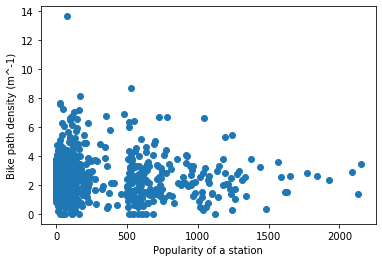

In [58]:
plt.scatter(bixi_subdata.counts, bixi_subdata.bp_density)
plt.ylabel('Bike path density (m^-1)')
plt.xlabel('Popularity of a station')
plt.show()

We would now like to get the average popularity of a trip for a given density.

In [59]:
bixi_subdata_to_plot = bixi_subdata.copy()
bixi_subdata_to_plot.bp_density = bixi_subdata_to_plot.bp_density.apply(lambda x: int(np.round(x-0.5)))
bixi_subdata_hist = bixi_subdata_to_plot.groupby('bp_density')['counts'].apply(np.mean)
bixi_subdata_hist.loc[9] = 0
bixi_subdata_hist.loc[10] = 0
bixi_subdata_hist.loc[11] = 0
bixi_subdata_hist.loc[12] = 0
bixi_subdata_hist = bixi_subdata_hist.sort_index(axis=0)
bixi_subdata_hist = bixi_subdata_hist.rename_axis('Bike path density between two stations')

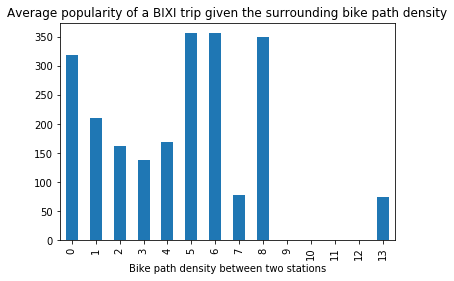

In [60]:
bixi_subdata_hist.plot.bar(x="Average number of use", y="Bike path density between two stations", title = 'Average popularity of a BIXI trip given the surrounding bike path density')

In [61]:
print("Correlation coefficient between the density of bicycle paths in the vicinity and the popularity of the same road: ")
print(bixi_subdata.counts.corr(bixi_subdata.bp_density))

Correlation coefficient between the density of bicycle paths in the vicinity and the popularity of the same road: 
-0.05794804683459805


The frequency of use of a particular path is not correlated here with the density of dedicated bicycle paths. The bike-friendliness of a road therefore has little impact on the frequency with which it is used.

# Integration into Public Transport

In [62]:
fname = "./BusLines/stm_lignes_sig.shp"
busl = gpd.read_file(fname)

### Metro lines

In [63]:
m_metro = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_metro)
folium.GeoJson(busl[:9],name='route_name').add_to(m_metro)
m_metro

In [64]:
m_metro.save("results/Matching_Bike_Path_Density_Chloropleth_Metro_Lines.html")

### Bus lines

In [65]:
m_bus = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bus)
folium.GeoJson(busl[10:491], style_function= lambda x :{'color': 'green','opacity':0.2}).add_to(m_bus)
#m_bus

In [66]:
#m_bus.save("results/Matching_Bike_Path_Density_Chloropleth_Bus_Lines.html")

In [67]:
%%HTML
<iframe width="100%" height="350" src="results/Matching_Bike_Path_Density_Chloropleth_Bus_Lines.html"></iframe>

### Compare Bixi station locations with Metro and Bus locations

In [68]:
stations = pd.read_csv('./BixiMontrealRentals/Stations_2019.csv', sep=',').set_index('code')

station_pointsx = np.array(stations.longitude.array)
station_pointsy = np.array(stations.latitude.array)
station_points = np.vstack((station_pointsy, station_pointsx)).T

m_metro_2 = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
HeatMap(station_points, radius = 10, min_opacity = 0.8).add_to(m_metro_2)
folium.GeoJson(busl[:9],name='route_name', style_function= lambda x :{'color': 'red','opacity':3}).add_to(m_metro_2)
m_metro_2

In [69]:
m_metro_2.save("results/Matching_Bixi_Stations_HeatMap-with_Metro_Lines.html")

In [70]:
m_bus_2 = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
HeatMap(station_points, radius = 10, min_opacity = 0.8).add_to(m_bus_2)
folium.GeoJson(busl[10:491], style_function= lambda x :{'color': 'green','opacity':0.2}).add_to(m_bus_2)
#m_bus_2

In [71]:
#m_bus_2.save("results/Matching_Bixi_Stations_HeatMap_with_Bus_Lines.html")

In [72]:
%%HTML
<iframe width="100%" height="350" src="results/Matching_Bixi_Stations_HeatMap_with_Bus_Lines.html"></iframe>

In [73]:
montreal = [45.5017, -73.5673]

mpath = folium.Map(location=montreal, tiles='cartodbpositron', zoom_start=12)

vis = paths.query('counts>600')

#plot lines between the stations according to number of trips taken
for index, row in vis.iterrows():
    folium.PolyLine([[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], color="blue", weight=row['counts']/500).add_to(mpath) 


folium.GeoJson(busl[:9],name='route_name', style_function= lambda x :{'color': 'red','opacity':3}).add_to(mpath)

    
mpath

In [74]:
mpath.save("results/metro_routes.html")

In [75]:
mbb = folium.Map(location=montreal, tiles='cartodbpositron', zoom_start=11)

#plot lines between the stations according to number of trips taken
for index, row in vis.iterrows():
    folium.PolyLine([[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], color="red", weight=row['counts']/500).add_to(mbb) 

folium.GeoJson(busl[10:491], style_function= lambda x :{'color': 'green','opacity':0.2}).add_to(mbb)

In [76]:
mbb.save("results/bus_routes.html")

In [77]:
%%HTML
<iframe width="100%" height="350" src="results/bus_routes.html"></iframe>

In [78]:
m_pops = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_pops)

for lat, lng, name, count in zip(stat50.latitude, stat50.longitude, stat50.start_station_code, stat50.counts):
    m_pops.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=count/5000, popup=name, fill_color='blue', color='blue'))
m_pops

In [79]:
m_pops.save("results/pop_stat_paths.html")

### Bus passage

Let's try to analyse following bus density instead of bus line density. STM provides files containing stop locations and the schedule of arrival times at bus stops. Both can be found [here](http://stm.info/en/about/developers).


For the next part  stops.txt and stop_times.txt need to be in the BusLines folder.

In [80]:
stops = pd.read_csv("BusLines/stops.txt")
stops.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,location_type,parent_station,wheelchair_boarding
0,STATION_M118,10118,STATION ANGRIGNON,45.446466,-73.603118,NaN,1,NaN,2
1,43,10118,Station Angrignon,45.446466,-73.603118,http://www.stm.info/fr/infos/reseaux/metro/ang...,0,STATION_M118,2
2,43-01,10118,Station Angrignon,45.446319,-73.603835,NaN,2,STATION_M118,2
3,STATION_M120,10120,STATION MONK,45.451158,-73.593242,NaN,1,NaN,2
4,42,10120,Station Monk,45.451158,-73.593242,http://www.stm.info/fr/infos/reseaux/metro/monk,0,STATION_M120,2


In [81]:
stop_times = pd.read_csv("BusLines/stop_times.txt", usecols=["trip_id", "stop_id", "stop_sequence"])
stop_times.head()

C:\Users\quent\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trip_id,stop_id,stop_sequence
0,209235722,51096,1
1,209235722,51140,2
2,209235722,51199,3
3,209235722,51227,4
4,209235722,51266,5


Approximately 4000 bus trips in the stop_times file are represented by a string instead of a number. The stops that they pass by are not included in stops.txt. 

We thus remove these trips as a side effect of an inner join.

In [82]:
#count the number of buses that pass by each stop
bus_numbers = pd.merge(stop_times.groupby(["stop_id"]).size().reset_index(name='counts'), 
                 stops[["stop_code", "stop_lat", "stop_lon"]], 
                 left_on="stop_id", 
                 right_on="stop_code")
bus_numbers

,stop_id,counts,stop_code,stop_lat,stop_lon
0,50101,1481,50101,45.594058,-73.542634
1,50102,867,50102,45.460511,-73.625831
2,50103,867,50103,45.458946,-73.626973
3,50104,584,50104,45.513581,-73.632259
4,50105,1690,50105,45.560876,-73.547179
...,...,...,...,...,...
8964,61824,725,61824,45.476806,-73.621329
8965,61825,29,61825,45.506849,-73.568260
8966,61826,688,61826,45.547326,-73.593148
8967,61828,12,61828,45.531191,-73.623651


We then need to look in which zone each stop is in.

In [84]:
from shapely.geometry import shape, Point

#map of the neighbourhoods
#can be found at http://donnees.ville.montreal.qc.ca/dataset/quartiers
with open('BusLines/quartierreferencehabitation.geojson') as f:
    js = json.load(f)

#add a column to store which neighbourhood the point is in.
bus_numbers["no_qr"] = ""

# check each polygon to see if it contains the point
for feature in js['features']:
    no_qr = feature["properties"]["no_qr"]
    polygon = shape(feature['geometry'])
    for index, row in bus_numbers.iterrows():
        if polygon.contains(Point(row['stop_lon'], row['stop_lat'])):
            bus_numbers.set_value(index, 'no_qr', no_qr)

bus_numbers

C:\Users\quent\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,stop_id,counts,stop_code,stop_lat,stop_lon,no_qr
0,50101,1481,50101,45.594058,-73.542634,21
1,50102,867,50102,45.460511,-73.625831,44
2,50103,867,50103,45.458946,-73.626973,44
3,50104,584,50104,45.513581,-73.632259,42
4,50105,1690,50105,45.560876,-73.547179,28
...,...,...,...,...,...,...
8964,61824,725,61824,45.476806,-73.621329,46
8965,61825,29,61825,45.506849,-73.568260,38
8966,61826,688,61826,45.547326,-73.593148,16
8967,61828,12,61828,45.531191,-73.623651,11


All thats left to do is to count the number of times a bus stopped per neighbourhood.

In [86]:
counts = bus_numbers.groupby(["no_qr"])["counts"].sum().reset_index(name="bus_per_day")
counts

,no_qr,bus_per_day
0,,105
1,01,88366
2,02,84704
3,03,94648
4,04,131994
...,...,...
87,89,108565
88,90,32305
89,91,23076
90,92,600


Let's plot !

In [87]:
montreal = [45.5017, -73.5673]
hm = folium.Map(location=montreal, tiles='Stamen Toner', zoom_start=12)
hm.choropleth(geo_data=js, data=counts,
             columns=['no_qr', 'bus_per_day'],
             key_on='feature.properties.no_qr',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Number of bus passes per day')
hm.save("results_bike_density.html")

C:\Users\quent\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


# Correlation with Weather

We want to make correlation and draw conclusion between weather factors and bike use. We'll try to suppress other factors (such as increasing popularity of bikeshare, increasing number of bike, ...) as much as possible.

## Increasing popularity of the bixi system

Let's visualise the evolution of the utilisation of the bike. In the following cells, we import the data and create a useful dataset for the analysis.

C:\Users\Ariane Acer\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'number of 10^4 bike travel of the month ')

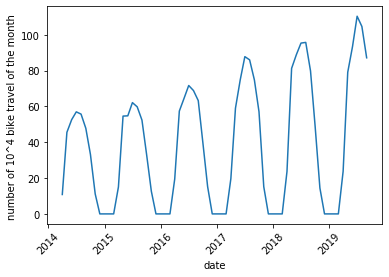

In [3]:
Monthly_BikeTravel = pd.read_pickle("../MonthlyBikeTravel")

Monthly_graph = plt.plot(Monthly_BikeTravel['date'],Monthly_BikeTravel['count']/10000)
plt.xticks(rotation = 45);

axes = plt.gca()
axes.set_xlabel('date')
axes.set_ylabel('number of 10^4 bike travel of the month ')

We clearly see the effect of the cycle of season : Bikes are not used between november and april.
Also as expected, bikes are more and more used.

## Normalization of the data

To try to suppress this tendency, we normalize the number of bike travel by the number of bike travel per year.

C:\Users\Ariane Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Ariane Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Ariane Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Text(0, 0.5, 'bike travel normalized by year')

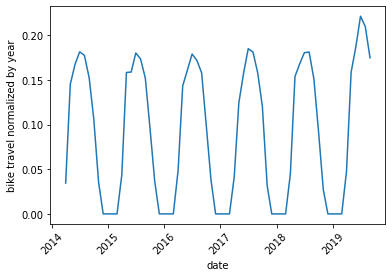

In [4]:
Annual_BikeTravel = pd.read_pickle("../Annual_BikeTravel")

year_2014 = Monthly_BikeTravel['date'].dt.year == 2014
data_2014 = Monthly_BikeTravel[year_2014]
data_2014['count'] = data_2014['count'].apply(lambda x: x/3136276)
data_2014 = data_2014.rename(columns={'count': 'normalized_count'})

year_2015 = Monthly_BikeTravel['date'].dt.year == 2015
data_2015 = Monthly_BikeTravel[year_2015]
data_2015['count'] = data_2015['count'].apply(lambda x: x/3443883)
data_2015 = data_2015.rename(columns={'count': 'normalized_count'})

year_2016 = Monthly_BikeTravel['date'].dt.year == 2016
data_2016 = Monthly_BikeTravel[year_2016]
data_2016['count'] = data_2016['count'].apply(lambda x: x/4000080)
data_2016 = data_2016.rename(columns={'count': 'normalized_count'})

year_2017 = Monthly_BikeTravel['date'].dt.year == 2017
data_2017 = Monthly_BikeTravel[year_2017]
data_2017['count'] = data_2017['count'].apply(lambda x: x/4740357)
data_2017 = data_2017.rename(columns={'count': 'normalized_count'})

year_2018 = Monthly_BikeTravel['date'].dt.year == 2018
data_2018 = Monthly_BikeTravel[year_2018]
data_2018['count'] = data_2018['count'].apply(lambda x: x/5277541)
data_2018 = data_2018.rename(columns={'count': 'normalized_count'})

year_2019 = Monthly_BikeTravel['date'].dt.year == 2019
data_2019 = Monthly_BikeTravel[year_2019]
data_2019['count'] = data_2019['count'].apply(lambda x: x/4980650)
data_2019 = data_2019.rename(columns={'count': 'normalized_count'})

Normalized_MonthlyBike = pd.concat([data_2014,data_2015,data_2016,data_2017,data_2018,data_2019])

plt.plot(Normalized_MonthlyBike['date'],Normalized_MonthlyBike['normalized_count'])
plt.xticks(rotation = 45);

axes = plt.gca()
axes.set_xlabel('date')
axes.set_ylabel('bike travel normalized by year')

We see that the trick seems to work, as the pike seems to have the same amplitude for each year, except 2019.
Difficult to say for 2019 but it may be due to the fact that the use of bike is not equally distributed over the year and that 2019 is not over.

Therefore we will exclude 2019 for the next of the analysis.

In [5]:
Daily_BikeTravel = pd.read_pickle("../DailyBikeTravel")

year_2014 = Daily_BikeTravel['date'].dt.year == 2014
data_2014 = Daily_BikeTravel[year_2014]
data_2014['count'] = data_2014['count'].apply(lambda x: x/3136276)
data_2014 = data_2014.rename(columns={'count': 'normalized_count'})

year_2015 = Daily_BikeTravel['date'].dt.year == 2015
data_2015 = Daily_BikeTravel[year_2015]
data_2015['count'] = data_2015['count'].apply(lambda x: x/3443883)
data_2015 = data_2015.rename(columns={'count': 'normalized_count'})

year_2016 = Daily_BikeTravel['date'].dt.year == 2016
data_2016 = Daily_BikeTravel[year_2016]
data_2016['count'] = data_2016['count'].apply(lambda x: x/4000080)
data_2016 = data_2016.rename(columns={'count': 'normalized_count'})

year_2017 = Daily_BikeTravel['date'].dt.year == 2017
data_2017 = Daily_BikeTravel[year_2017]
data_2017['count'] = data_2017['count'].apply(lambda x: x/4740357)
data_2017 = data_2017.rename(columns={'count': 'normalized_count'})

year_2018 = Daily_BikeTravel['date'].dt.year == 2018
data_2018 = Daily_BikeTravel[year_2018]
data_2018['count'] = data_2018['count'].apply(lambda x: x/5277541)
data_2018 = data_2018.rename(columns={'count': 'normalized_count'})

year_2019 = Daily_BikeTravel['date'].dt.year == 2019
data_2019 = Daily_BikeTravel[year_2019]
data_2019['count'] = data_2019['count'].apply(lambda x: x/4980650)
data_2019 = data_2019.rename(columns={'count': 'normalized_count'})

Normalized_DailyBike = pd.concat([data_2014,data_2015,data_2016,data_2017,data_2018,data_2019])

C:\Users\Ariane Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Ariane Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Ariane Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

## Cleaning of the weather dataset

In [6]:
weather_2014 = pd.read_csv(r"WeatherData\2014.csv",sep = ',')
weather_2015 = pd.read_csv(r"WeatherData\2015.csv",sep = ',')
weather_2016 = pd.read_csv(r"WeatherData\2016.csv",sep = ',')
weather_2017 = pd.read_csv(r"WeatherData\2017.csv",sep = ',')
weather_2018 = pd.read_csv(r"WeatherData\2018.csv",sep = ',')
weather_2019 = pd.read_csv(r"WeatherData\2019.csv",sep = ',')

data = pd.concat([weather_2014,weather_2015,weather_2016,weather_2017,weather_2018,weather_2019])

# Selection of useful data
df_weather = data[['Date/Heure','Temp moy.(°C)','Précip. tot. (mm)', 'Neige au sol (cm)', 'Vit. raf. max. (km/h)']]

# Conversion to datetime
df_weather['datetime'] = df_weather.apply(lambda row: datetime.datetime.strptime(row['Date/Heure'], '%Y-%m-%d'), 
                        axis=1)
df_weather = df_weather.rename(columns={'datetime': 'Date'})
df_weather.drop(['Date/Heure'],axis='columns', inplace=True)

C:\Users\Ariane Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### Temperature care

Problem with the temperature is, as the website is in french, number are written such as 5,6 instead of 5.6.

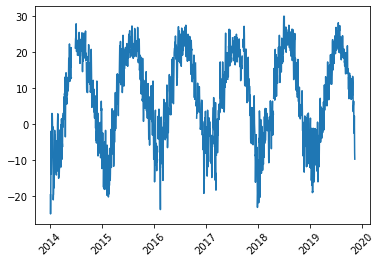

In [7]:
# Conversion of string into float
df_temp = df_weather [['Date','Temp moy.(°C)']]
df_temp = df_temp.dropna()

# This conversion function need all NaN to be suppressed
df_temp['Mean temp (°C)'] = df_temp.apply(lambda row: float(row['Temp moy.(°C)'].replace(',','.')), axis=1)
df_temp.drop(['Temp moy.(°C)'],axis='columns', inplace=True)

# Creation of a date dataframe to fill the missing date
rng = pd.date_range('2014-04-15', periods=1995, freq='D')
calendar = pd.DataFrame({ 'date': rng, 'Count' : 0 }) 

# Put again the missing date
df_temp = pd.merge(df_temp, calendar, how='outer', on=None, left_on='Date', right_on='date',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

df_temp.drop(['Count'],axis='columns', inplace=True)
df_temp.drop(['date'],axis='columns', inplace=True)

# Visualisation of data

plt.plot(df_temp['Date'],df_temp['Mean temp (°C)'])
plt.xticks(rotation = 45);

### Precipitation care

Same for precipitation

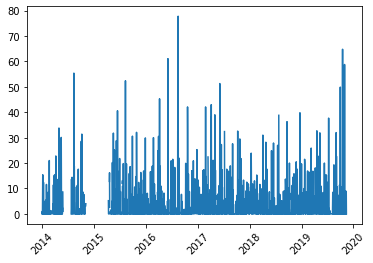

In [8]:
# Conversion of string into float
df_rain = df_weather [['Date','Précip. tot. (mm)']]
df_rain = df_rain.dropna()

# This conversion function need all NaN to be suppressed
df_rain['Tot precip (mm)'] = df_rain.apply(lambda row: float(row['Précip. tot. (mm)'].replace(',','.')), axis=1)
df_rain.drop(['Précip. tot. (mm)'],axis='columns', inplace=True)

# Put again the missing date
df_rain = pd.merge(df_rain, calendar, how='outer', on=None, left_on='Date', right_on='date',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

df_rain.drop(['Count'],axis='columns', inplace=True)
df_rain.drop(['date'],axis='columns', inplace=True)

# Visualisation of data

plt.plot(df_rain['Date'],df_rain['Tot precip (mm)'])
plt.xticks(rotation = 45);

Seems that there is a huge gap of missing value around beginning of the year 2015.

### Snow care

Data type is already float.

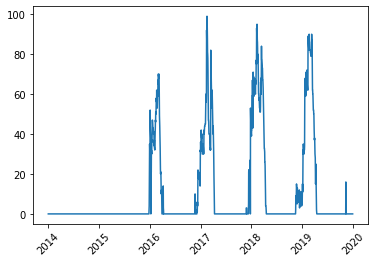

In [9]:
df_snow = df_weather [['Date','Neige au sol (cm)']]

# change le nom
df_snow = df_snow.rename(columns={'Neige au sol (cm)': 'Snow on ground (cm)'})

# Fill the missing value with 0
df_snow = df_snow.fillna(0)

# Visualisation of data

plt.plot(df_snow['Date'],df_snow['Snow on ground (cm)'])
plt.xticks(rotation = 45);

It seems that the dataset do not contain snow data before 2016. We'll have to keep it in mind and to not uses these data before 2016.

### Wind care

Problem with wind is that we do not dispose of wind data below 31 km/h.
We'll drop rows containing this value to keep only quantitative data.

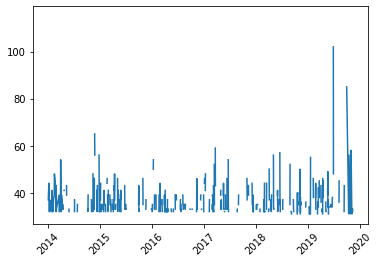

In [10]:
df_wind = df_weather [['Date','Vit. raf. max. (km/h)']]
df_wind.head()

# We drop rows with '<31'
df_wind = df_wind[df_wind['Vit. raf. max. (km/h)'] != '<31']
df_wind = df_wind.dropna()

# This conversion function need all NaN to be suppressed
df_wind['Wind max speed (km/h)'] = df_wind.apply(lambda row: float(row['Vit. raf. max. (km/h)']), axis=1)
df_wind.drop(['Vit. raf. max. (km/h)'],axis='columns', inplace = True)

# Put again the missing date
df_wind = pd.merge(df_wind, calendar, how='outer', on=None, left_on='Date', right_on='date',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

df_wind.drop(['Count'],axis='columns', inplace = True)
df_wind.drop(['date'],axis='columns', inplace = True)

# Visualisation of data

plt.plot(df_wind['Date'],df_wind['Wind max speed (km/h)'])
plt.xticks(rotation = 45);

### Creation of the cleaned dataset

In [11]:
weather_TempRain = pd.merge(df_temp, df_rain, how='inner', on=None, left_on='Date', right_on='Date',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

weather_TempRain = weather_TempRain.dropna()

weather_withoutWind = pd.merge(weather_TempRain, df_snow, how='outer', on=None, left_on='Date', right_on='Date',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

weather_withoutWind = weather_withoutWind.dropna()

cleaned_weather = pd.merge(weather_withoutWind, df_wind, how='outer', on=None, left_on='Date', right_on='Date',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

cleaned_weather = cleaned_weather.dropna(subset=['Date'])

Now we should merge this last dataframe with the bike use data.

In [12]:
total_dataset = pd.merge(cleaned_weather, Normalized_DailyBike, how='outer', on=None, left_on='Date', 
                         right_on='date', left_index=False, right_index=False, sort=True, suffixes=('_x', '_y'), 
                         copy=True, indicator=False, validate=None)

total_dataset = total_dataset.dropna(subset=['normalized_count'])

total_dataset.drop(['date'],axis='columns', inplace = True)

For the next of the code, we don't want to take into account month where the bixi system is closed. So we drop the month where it is the case. Also we do want a dataset with date beyond 2016 in order to have relevent snow values and we don't use 2019 values because of normalization failure.

In [13]:
total_dataset = total_dataset[total_dataset['normalized_count'] != 0]

year_2016 = total_dataset['Date'].dt.year == 2016
data_2016 = total_dataset[year_2016]

year_2017 = total_dataset['Date'].dt.year == 2017
data_2017 = total_dataset[year_2017]

year_2018 = total_dataset['Date'].dt.year == 2018
data_2018 = total_dataset[year_2018]

total_dataset_beyond2016 = pd.concat([data_2016,data_2017,data_2018])

## Ridge regression

In order to assess which parameters are the most important, we use Ridge regression.
We must have no missing value to do the following analysis, so we have to make a choice.
If we use the wind, we will consider only days with Wind max > 31 km/h.

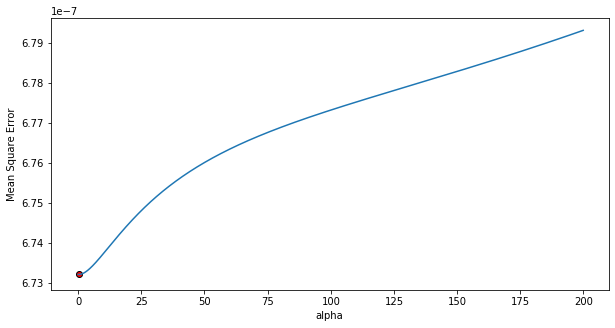

Optimized alpha :  0.30000000000000004
Minimal mean square error : 6.793186450376873e-07


In [14]:
First_regression = total_dataset_beyond2016.dropna()

parameters = ['normalized_count', 'Mean temp (°C)','Tot precip (mm)', 'Snow on ground (cm)', 
              'Wind max speed (km/h)']
y = First_regression[parameters[0]]
X = First_regression[parameters[1:]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Normalisation

X = scale(X, axis = 0)

# find the alpha for which mse (mean square error) is minimal

train_mse = [] # will contain mse value for each alpha in (0:2000)

# alpha = 0

ridge = Ridge(alpha=0)  #creation of the model
predicted_r = cross_val_predict(ridge, X_train, y_train, cv=5)
alpha_min = 0  #initialize alpha_min
min_mse = mean_squared_error(y_train, predicted_r)  #initialize min_mse
train_mse.append(min_mse)

# alpha in (1:2000)

for alpha_i in np.arange(0.1, 200, 0.1):
    ridge = Ridge(alpha=alpha_i)
    predicted_r = cross_val_predict(ridge, X_train, y_train, cv=5)
    mse_i = mean_squared_error(y_train, predicted_r)
    train_mse.append(mse_i)    
    if mse_i < min_mse:
        alpha_min = alpha_i
        min_mse = mse_i
        
# Which alpha is optimal ?

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(0, 200, 0.1),train_mse)
ax.scatter([alpha_min], [min_mse], edgecolors=(0, 0, 0), color = 'r')
ax.set_xlabel('alpha')
ax.set_ylabel('Mean Square Error')
plt.show()
print("Optimized alpha : ", alpha_min)
print("Minimal mean square error :", mean_squared_error(y_train, predicted_r))

finally we do the regression with the chosen alpha and take a look at the coefficient

In [15]:
ridge = Ridge(alpha=alpha_min)
predicted_r = cross_val_predict(ridge, X_train, y_train, cv=5)

ridge.fit(X_train, y_train)

ridge.coef_

array([ 1.83934319e-04, -7.22697522e-05, -1.48001051e-04, -1.89050845e-05])

These 4 numbers are the coefficients corresponding on the impact of temperature, precipitation, snow on ground and wind max speed respectively.

If we recapitulate, temperature has a positive influence, and rain, snow, and wind a negative one, as expected.
The major influence is given by temperature, as it is the max absolute value among the coefficient.
However we must keep in mind that this is only valid by day of high wind (> 31 km/h)

We'll do further analysis, considering only the first three columns.

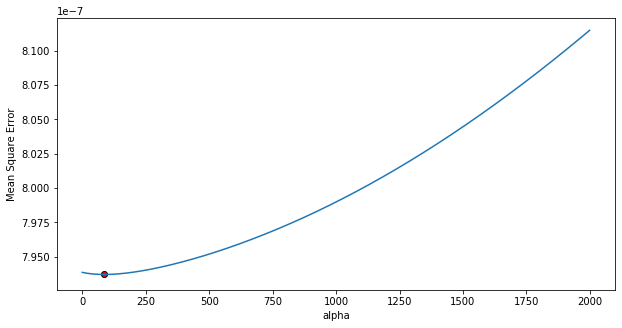

Optimized alpha :  87
Minimal mean square error : 8.114884720660402e-07


In [16]:
Second_regression = total_dataset_beyond2016[['Date','Mean temp (°C)','Tot precip (mm)','Snow on ground (cm)',
                                   'normalized_count']]

Second_regression = Second_regression.dropna()

parameters = ['normalized_count', 'Mean temp (°C)','Tot precip (mm)', 'Snow on ground (cm)']
y = Second_regression[parameters[0]]
X = Second_regression[parameters[1:]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Normalisation

X = scale(X, axis = 0)

# find the alpha for which mse (mean square error) is minimal

train_mse = [] # will contain mse value for each alpha in (0:2000)

# alpha = 0

ridge = Ridge(alpha=0)  #creation of the model
predicted_r = cross_val_predict(ridge, X_train, y_train, cv=5)
alpha_min = 0  #initialize alpha_min
min_mse = mean_squared_error(y_train, predicted_r)  #initialize min_mse
train_mse.append(min_mse)

# alpha in (1:2000)

for alpha_i in range(1, 2000):
    ridge = Ridge(alpha=alpha_i)
    predicted_r = cross_val_predict(ridge, X_train, y_train, cv=5)
    mse_i = mean_squared_error(y_train, predicted_r)
    train_mse.append(mse_i)    
    if mse_i < min_mse:
        alpha_min = alpha_i
        min_mse = mse_i
        
# Which alpha is optimal ?

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_mse)
ax.scatter([alpha_min], [min_mse], edgecolors=(0, 0, 0), color = 'r')
ax.set_xlabel('alpha')
ax.set_ylabel('Mean Square Error')
plt.show()
print("Optimized alpha : ", alpha_min)
print("Minimal mean square error :", mean_squared_error(y_train, predicted_r))

In [17]:
ridge = Ridge(alpha=alpha_min)
predicted_r = cross_val_predict(ridge, X_train, y_train, cv=5)

ridge.fit(X_train, y_train)

ridge.coef_

array([ 1.72323698e-04, -7.82654802e-05, -5.90781277e-05])

Once again, temperature is a positive factor and rain and snow are negative ones.
This time temperature is the principal factor in Montreal that will make you decide whether or not you will use the public bike.

## Prediction

Now that we have such a model, we could try to predict what would be the bike use during winter if the bikeshare system was not closed, to see whether or not the closing month choice is appropriate.

We will use the coefficient of the second Ridge Regression, during years 2016, 2017 and 2018. To that end, we must use normalized data of the winter month.

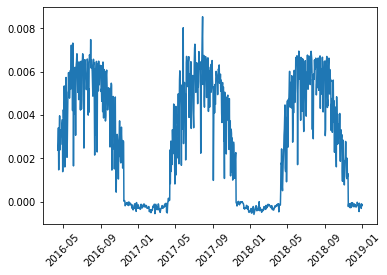

In [18]:
# Selecting years 2016, 2017 and 2018

year_2016 = cleaned_weather['Date'].dt.year == 2016
data_2016 = cleaned_weather[year_2016]

year_2017 = cleaned_weather['Date'].dt.year == 2017
data_2017 = cleaned_weather[year_2017]

year_2018 = cleaned_weather['Date'].dt.year == 2018
data_2018 = cleaned_weather[year_2018]

cleaned_weather_of_interest = pd.concat([data_2016, data_2017, data_2018])

# Normalization of parameters

parameters = ['Mean temp (°C)','Tot precip (mm)','Snow on ground (cm)']
X = cleaned_weather_of_interest[parameters]
X = scale(X, axis = 0)
X = pd.DataFrame(X, columns = ['normalized_temperature', 'normalized_precipitation', 'normalized_snow on ground'])

# Trick in order to put the right date to the normalized parameters

cleaned_weather_of_interest['new'] = range(1073)
X['new'] = range(1073)

normalized_weather_of_interest = pd.merge(cleaned_weather_of_interest, X, how='inner', on=None, left_on='new', 
                                          right_on='new', left_index=False, right_index=False, sort=True, 
                                          suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

normalized_weather_of_interest = normalized_weather_of_interest[['Date','normalized_temperature',
                                                                 'normalized_precipitation', 
                                                                 'normalized_snow on ground']]

# We select the winter months

rng = pd.date_range('2016-10-16', periods=181, freq='D')
calendar_winter_2016 = pd.DataFrame({ 'date': rng}) 

rng = pd.date_range('2017-10-16', periods=181, freq='D')
calendar_winter_2017 = pd.DataFrame({ 'date': rng}) 

rng = pd.date_range('2018-10-16', periods=181, freq='D')
calendar_winter_2018 = pd.DataFrame({ 'date': rng}) 

winter = pd.concat([calendar_winter_2016, calendar_winter_2017, calendar_winter_2018])

winter_weather = pd.merge(normalized_weather_of_interest, winter, how='inner', on=None, left_on='Date', 
                          right_on='date', left_index=False, right_index=False, sort=True, suffixes=('_x', '_y'), 
                          copy=True, indicator=False, validate=None)

winter_weather.drop(['date'],axis='columns', inplace = True)

# We do the prediction

winter_weather['predicted_count'] = 1.72323698e-04 * winter_weather['normalized_temperature'] -7.82654802e-05 * winter_weather['normalized_precipitation']-5.90781277e-05 * winter_weather['normalized_snow on ground']

winter_prediction = winter_weather[['Date','predicted_count']]

# We merge with the bike travel dataset in order to compare

completed_dataset = pd.merge(total_dataset_beyond2016, winter_prediction, how='outer', on=None, left_on='Date', 
                          right_on='Date', left_index=False, right_index=False, sort=True, suffixes=('_x', '_y'), 
                          copy=True, indicator=False, validate=None)

completed_dataset = completed_dataset[['Date','normalized_count','predicted_count']]
completed_dataset = completed_dataset.fillna(0)
completed_dataset['normalized_count'] = completed_dataset['normalized_count'] + completed_dataset['predicted_count']
completed_dataset.drop(['predicted_count'],axis='columns', inplace = True)

# We visualize the result

plt.plot(completed_dataset['Date'],completed_dataset['normalized_count'])
plt.xticks(rotation = 45);

We see that during closure (16th of October to the 14th of April), the predictive model we built shows value almost null. 
Temperature, rain and snow during this month would discourage bike use...

It is relevant that the system close during that time, and no change is adviced.